In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import gc
import psutil
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import collections
import warnings
from enum import Enum
import time
from copy import deepcopy
from joblib import Parallel, delayed

<h2> CliffWalking Grid </h2>

<b>Problem Credit:</b> Alberta Machine Learning Institute <br/><br/>
The Cliff Walking environment is a gridworld with a discrete state space and discrete action space. The agent starts at grid cell S. The agent can move (deterministically) to the four neighboring cells by taking actions Up, Down, Left or Right. Trying to move out of the boundary results in staying in the same location. So, for example, trying to move left when at a cell on the leftmost column results in no movement at all and the agent remains in the same location. The agent receives -1 reward per step in most states, and -100 reward when falling off of the cliff. This is an episodic task; termination occurs when the agent reaches the goal grid cell G. Falling off of the cliff results in resetting to the start state, without termination.
<img src="Cliff-GridWorld.png" style="height:300px">

<b> TD(0) Algorithm for Policy Iteration (Uniform Random)

In [7]:
class policy(Enum):
    LEFT, RIGHT, UP, DOWN = 1, 2, 3, 4
pol = {(r, c):{policy.LEFT:0.25, policy.RIGHT:0.25, policy.UP:0.25, policy.DOWN:0.25} for r in range(3)
         for c in range(12)}
pol[(3,0)] = {policy.LEFT:0.25, policy.RIGHT:0.25, policy.UP:0.25, policy.DOWN:0.25}
def get_start():
    return (3,0)
def is_terminal(state):
    return (state[0]==3) and (state[1]==11)

In [8]:
#Predetact provides support for pre-determined actions
def get_move(state, pol, predetact=None):
    action, newstate, reward = np.random.uniform(low=0, high=1), None, None
    if ((action<pol[state][policy.LEFT]) and (predetact==None)) or (predetact==policy.LEFT):
        action=policy.LEFT
        newstate, reward = (state[0], state[1]-1), -1
    elif ((action<(pol[state][policy.LEFT]+pol[state][policy.RIGHT])) and 
          (predetact==None)) or (predetact==policy.RIGHT):
        action=policy.RIGHT
        newstate, reward = (state[0], state[1]+1), -1
    elif ((action<(1-pol[state][policy.DOWN])) and (predetact==None)) or (predetact==policy.UP):
        action=policy.UP
        newstate, reward = (state[0]-1, state[1]), -1
    else:
        action=policy.DOWN
        newstate, reward = (state[0]+1, state[1]),-1
    if (newstate[0]<0) or (newstate[0]>3) or (newstate[1]<0) or (newstate[1]>11):
        newstate, reward = state, -1
    if (newstate[0]==3) and (newstate[1]!=0) and (newstate[1]!=11):
        newstate, reward = (3,0), -100
    if is_terminal(newstate):
        reward = 200-1
    return action, reward, newstate

In [9]:
def one_episode_TD0(pol, stepsize, values):
    state=get_start()
    newvalues = values.copy()
    while (not is_terminal(state)):
        action, reward, newstate = get_move(state, pol)
        newvalues[state[0], state[1]] += stepsize*(reward+newvalues[newstate[0], newstate[1]]-
                                                newvalues[state[0], state[1]])
        state = newstate
    return newvalues

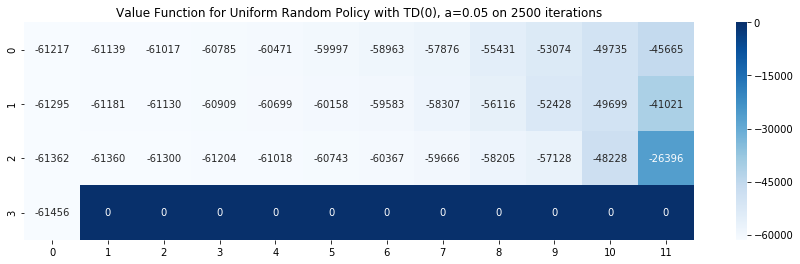

In [5]:
stepsize = 0.05
iterations = 2500
values = np.zeros((4,12))
for i in range(iterations):
    values = one_episode_TD0(pol, stepsize, values)
plt.figure(figsize=(15,4))
sns.heatmap(values, cmap="Blues", annot=True, fmt='.0f')
plt.title("Value Function for Uniform Random Policy with TD(0), a="+str(stepsize)+" on "
          +str(iterations)+" iterations")
plt.show()

<b> TD(0) Algorithm for Policy Iteration (Safe Policy On Image)

In [10]:
pol = {(r, c):{policy.LEFT:0.0, policy.RIGHT:0.0, policy.UP:0.0, policy.DOWN:0.0} for r in range(1,3)
         for c in range(1,11)}
pol[(3,11)] = {policy.LEFT:0.0, policy.RIGHT:0.0, policy.UP:0.0, policy.DOWN:0.0}
for c in range(11):
    pol[(0,c)] = {policy.LEFT:0.0, policy.RIGHT:1.0, policy.UP:0.0, policy.DOWN:0.0}
pol[(0,11)] = {policy.LEFT:0.0, policy.RIGHT:0.0, policy.UP:0.0, policy.DOWN:1.0}
for r in range(1,3):
    pol[(r,0)] = {policy.LEFT:0.0, policy.RIGHT:0.0, policy.UP:1.0, policy.DOWN:0.0}
    pol[(r,11)] = {policy.LEFT:0.0, policy.RIGHT:0.0, policy.UP:0.0, policy.DOWN:1.0}
pol[(3,0)] = {policy.LEFT:0.0, policy.RIGHT:0.0, policy.UP:1.0, policy.DOWN:0.0}

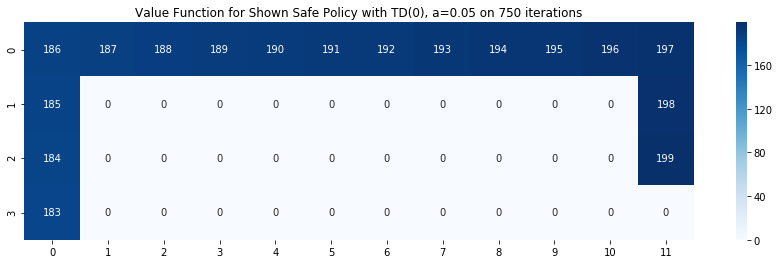

In [7]:
stepsize = 0.05
iterations = 750
values = np.zeros((4,12))
for i in range(iterations):
    values = one_episode_TD0(pol, stepsize, values)
plt.figure(figsize=(15,4))
sns.heatmap(values, cmap="Blues", annot=True, fmt='.0f')
plt.title("Value Function for Shown Safe Policy with TD(0), a="+str(stepsize)+" on "
          +str(iterations)+" iterations")
plt.show()

<b>SARSA Algorithm for Value Iteration (Epsilon-Greedy and Exploring Starts)

In [11]:
#Epsilon-Greedy Helpers
def epsilon_greedy_updater(actdict, pol, s, a, r, nvl, stepsize, epsilon):
    actdict[s][a] += stepsize*(r+nvl-actdict[s][a])
    bestmove = max(actdict[s], key=actdict[s].get)
    numbestmove = 0
    for i in range(1,5):
        if actdict[s][policy(i)]==actdict[s][bestmove]:
            numbestmove+=1
    for i in range(1,5):
        if actdict[s][policy(i)]==actdict[s][bestmove]:
            pol[s][policy(i)] = (1-(4-numbestmove)/4*epsilon)/numbestmove
        else:
            pol[s][policy(i)] = epsilon/4
def epsilon_greedy_starter(pol):
    state1 = get_start()
    action1, reward1, state2 = get_move(state1, pol)
    return state1, action1, reward1, state2

In [24]:
#Exploring Starts Helpers
def exploring_starts_updater(actdict, pol, s, a, r, nvl, stepsize):
    actdict[s][a] += stepsize*(r+nvl-actdict[s][a])
    bestmove = max(actdict[s], key=actdict[s].get)
    numbestmove = 0
    for i in range(1,5):
        if actdict[s][policy(i)]==actdict[s][bestmove]:
            numbestmove+=1
    for i in range(1,5):
        pol[s][policy(i)] = 1/numbestmove if actdict[s][policy(i)]==actdict[s][bestmove] else 0
def exploring_starts_starter(pol):
    cell = np.random.choice(34, replace=False)
    state1 = (np.int(cell/11), cell%11)
    action1 = policy(np.random.choice(4)+1)
    action1, reward1, state2 = get_move(state1, pol, action1)
    return state1, action1, reward1, state2

In [25]:
def one_episode_sarsa(stepsize, actdict, pol, starterfunc, updaterfunc, **kwargs):
    state1, action1, reward1, state2 = starterfunc(pol)
    totalrwd = reward1
    while (not is_terminal(state2)):
        action2, reward2, tmpstate = get_move(state2, pol)
        totalrwd += reward2
        updaterfunc(actdict, pol, state1, action1, reward1, actdict[state2][action2], stepsize, **kwargs)
        state1, action1, reward1, state2 = state2, action2, reward2, tmpstate
    updaterfunc(actdict, pol, state1, action1, reward1, 0, stepsize, **kwargs)
    return totalrwd

In [26]:
def sarsa_simulation(stepsize, iterations, starterfunc, updaterfunc, **kwargs):
    actdict = {(r, c):{policy.LEFT:0, policy.RIGHT:0, policy.UP:0, policy.DOWN:0} for r in range(3)
         for c in range(12)}
    actdict[(3,0)] = {policy.LEFT:0, policy.RIGHT:0, policy.UP:0, policy.DOWN:0}
    pol = {(r, c):{policy.LEFT:0.25, policy.RIGHT:0.25, policy.UP:0.25, policy.DOWN:0.25} for r in range(3)
         for c in range(12)}
    pol[(3,0)] = {policy.LEFT:0.25, policy.RIGHT:0.25, policy.UP:0.25, policy.DOWN:0.25}
    rewards = np.zeros(iterations)
    for i in range(iterations):
        rewards[i] = one_episode_sarsa(stepsize, actdict, pol, starterfunc, updaterfunc, **kwargs)
    return actdict, pol, rewards

In [31]:
start = time.time()
egactdict, egpol, egrwd = sarsa_simulation(0.05, 250000, epsilon_greedy_starter, epsilon_greedy_updater, epsilon=0.2)
print("Epsilon Greedy SARSA Simulation ended in "+str(time.time()-start)+" seconds")
start = time.time()
esactdict, espol, esrwd = sarsa_simulation(0.05, 250000, exploring_starts_starter, exploring_starts_updater)
print("Exploring Starts SARSA Simulation ended in "+str(time.time()-start)+" seconds")

Epsilon Greedy SARSA Simulation ended in 128.71954202651978 seconds
Exploring Starts SARSA Simulation ended in 61.7470760345459 seconds


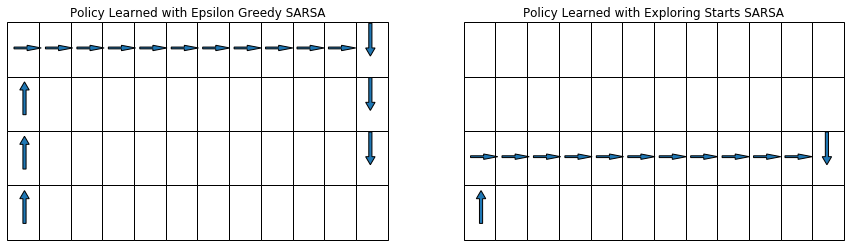

In [15]:
def plotter(actdict, ax):
    state = get_start()
    ax.table(cellText=np.zeros((4,12), dtype='<U1'), loc='center', bbox=[0,0,1,1])
    while (not is_terminal(state)):
        action = max(actdict[state], key=actdict[state].get)
        xlen, ylen, i, j = 1/12, 1.1/4, state[0], state[1]
        if action==policy.LEFT:
            plt.arrow(xlen*(1.2*j+1), ylen*(4-1.1*i-0.5), -xlen/2, 0, width=0.01)
        elif action==policy.RIGHT:
            plt.arrow(xlen*(1.2*j-1), ylen*(4-1.1*i-0.5), xlen/2, 0, width=0.01)
        elif action==policy.UP:
            plt.arrow(xlen*(1.2*j)-0.05, ylen*(4-1.1*i-0.75), 0, ylen/2, width=0.01)
        elif action==policy.DOWN:
            plt.arrow(xlen*(1.2*j)-0.05, ylen*(4-1.1*i), 0, -ylen/2, width=0.01)
        _, _, state = get_move(state, pol, max(actdict[state], key=actdict[state].get))
    ax.axis("tight")
    ax.axis("off")
plt.figure(figsize=(15,4))
ax = plt.subplot(1,2,1)
plotter(egactdict, ax)
plt.title("Policy Learned with Epsilon Greedy SARSA")
ax = plt.subplot(1,2,2)
plotter(esactdict, ax)
plt.title("Policy Learned with Exploring Starts SARSA")
plt.show()

We notice that the Epsilon-Greedy SARSA learns a sub-optimal policy compared to exploring starts. We can mathematically reason this from the SARSA algorithm. Specifically, falling from the cliff has excessively high negative reward at 100 so any algorithm learns to avoid the cliff. However, in epsilon-greedy, since $_frac{\epsilon}{4}$ probability of every non-optimal action is ensured in the policy, there is non-zero probability of falling from the cliff over many episodes in row 2. Thus, the expected value of the state falls conditioned on that large negative reward, making the choice of policy more risk averse as the additional -4 from taking the longer route is lower than the risk of falling in epsilon-greedy. An exploring starts avoids this by maintaining purely deterministic policies, and thus manages to actually learn the optimal policy in this case. We now proceed to compare the performance over varied levels of initialization parameters.

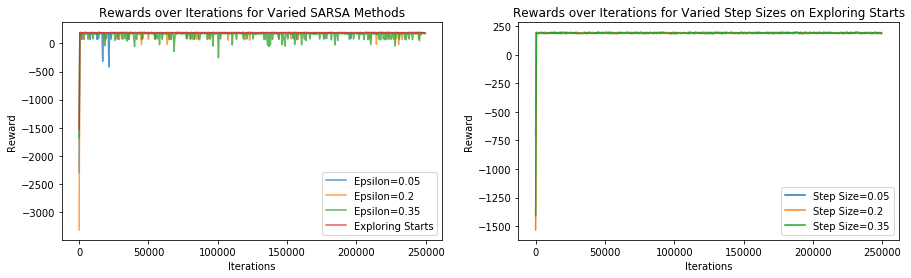

In [36]:
#Modifications to Method
plt.figure(figsize=(15,4))
plt.subplot(1,2,1)
epsilons = [0.05, 0.2, 0.35]
for ep in epsilons:
    _, _, rwd = sarsa_simulation(0.05, 250000, epsilon_greedy_starter, epsilon_greedy_updater, epsilon=ep)
    pd.Series(rwd)[::500].plot(label="Epsilon="+str(ep), alpha=0.75)
pd.Series(esrwd)[::500].plot(label="Exploring Starts", alpha=0.75)
plt.legend(loc="best")
plt.xlabel("Iterations")
plt.ylabel("Reward")
plt.title("Rewards over Iterations for Varied SARSA Methods")
#Modifications to Step-Size
plt.subplot(1,2,2)
stepsizes = [0.05, 0.2, 0.35]
for ss in stepsizes:
    _, _, rwd = sarsa_simulation(ss, 250000, exploring_starts_starter, exploring_starts_updater)
    pd.Series(rwd)[::500].plot(label="Step Size="+str(ss))
plt.legend(loc="best")
plt.xlabel("Iterations")
plt.ylabel("Reward")
plt.title("Rewards over Iterations for Varied Step Sizes on Exploring Starts")
plt.show()

<h2> Windy Gridworld </h2>

We now use a standard gridworld as before, with start and goal states, but with a crosswind running upward through the middle of the grid. The actions are the standard up, down, right, and left, but the resultant next states are shifted upward by the strength of the wind.

In [43]:
def get_move(state, boardshape, terminal, wind, pol, predetact=None):
    action, newstate, reward = np.random.uniform(low=0, high=1), None, None
    if ((action<pol[state][policy.LEFT]) and (predetact==None)) or (predetact==policy.LEFT):
        action=policy.LEFT
        newstate, reward = (state[0]+wind[state[1]], state[1]-1), -1
    elif ((action<(pol[state][policy.LEFT]+pol[state][policy.RIGHT])) and 
          (predetact==None)) or (predetact==policy.RIGHT):
        action=policy.RIGHT
        newstate, reward = (state[0]+wind[state[1]], state[1]+1), -1
    elif ((action<(1-pol[state][policy.DOWN])) and (predetact==None)) or (predetact==policy.UP):
        action=policy.UP
        newstate, reward = (state[0]+wind[state[1]]-1, state[1]), -1
    else:
        action=policy.DOWN
        newstate, reward = (state[0]+wind[state[1]]+1, state[1]),-1
    if newstate[0]<0: newstate = (0, newstate[1])
    if newstate[0]>=boardshape[0]: newstate = (boardshape[0]-1, newstate[1])
    if newstate[1]<0: newstate = (newstate[0], 0)
    if newstate[1]>=boardshape[1]: newstate = (newstate[0], boardshape[1]-1)
    if newstate==terminal: reward=100
    return action, reward, newstate

In [60]:
#Exploring Starts Helpers
def exploring_starts_starter(boardshape, terminal, wind, pol):
    state1=terminal
    while state1==terminal:
        cell = np.random.choice(boardshape[0]*boardshape[1], replace=False)
        state1 = (np.int(cell/boardshape[1]), cell%boardshape[1])
    action1 = policy(np.random.choice(4)+1)
    action1, reward1, state2 = get_move(state1, boardshape, terminal, wind, pol, action1)
    return state1, action1, reward1, state2

In [69]:
def one_episode_sarsa(stepsize, actdict, pol, boardshape, terminal, wind):
    state1, action1, reward1, state2 = exploring_starts_starter(boardshape, terminal, wind, pol)
    totalrwd = reward1
    while state2!=terminal:
        action2, reward2, tmpstate = get_move(state2, boardshape, terminal, wind, pol)
        totalrwd += reward2
        exploring_starts_updater(actdict, pol, state1, action1, reward1, actdict[state2][action2], stepsize)
        state1, action1, reward1, state2 = state2, action2, reward2, tmpstate
    exploring_starts_updater(actdict, pol, state1, action1, reward1, 0, stepsize)
    return totalrwd
def sarsa_simulation(stepsize, iterations, boardshape, terminal, wind):
    actdict = {(r, c):{policy.LEFT:0, policy.RIGHT:0, policy.UP:0, policy.DOWN:0} for r in range(boardshape[0])
         for c in range(boardshape[1])}
    pol = {(r, c):{policy.LEFT:0.25, policy.RIGHT:0.25, policy.UP:0.25, policy.DOWN:0.25} 
           for r in range(boardshape[0]) for c in range(boardshape[1])}
    rewards = np.zeros(iterations)
    for i in range(iterations):
        rewards[i] = one_episode_sarsa(stepsize, actdict, pol, boardshape, terminal, wind)
    return actdict, pol, rewards

APPLICABLE WIND:NONE, UP:1, UP:2, DOWN:3, UP:2, DOWN:1, NONE


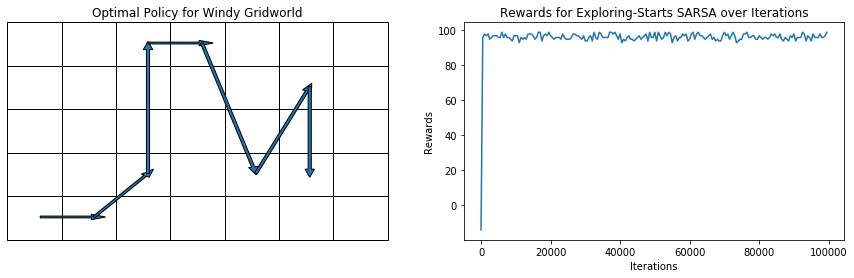

In [112]:
boardshape = (5,7)
colwind = [0, -1, -2, 3, -2, 1, 0]
start, terminal = (4,0), (3,5)
actdict, pol, rwd = sarsa_simulation(0.05, 100000, boardshape, terminal, colwind)
at = np.vectorize(lambda s: "UP:"+str(np.abs(s)) if s<0 else "DOWN:"+str(s) if s>0 else "NONE")(np.array(colwind))
at = "APPLICABLE WIND:"+", ".join(at)
print(at)
plt.figure(figsize=(15,4))
ax = plt.subplot(1,2,1)
ax.table(cellText=np.zeros(boardshape, dtype='<U1'), bbox=[0,0,1,1])
state=start
while state!=terminal:
    action = max(actdict[state], key=actdict[state].get)
    _, _, newstate = get_move(state, boardshape, terminal, colwind, pol, 
                              max(actdict[state], key=actdict[state].get))
    xlen, ylen = 1/boardshape[1], 1.1/boardshape[0]
    plt.arrow(xlen*(1.2*state[1]), ylen*(4-1.1*state[0]+0.5), 0.95*(xlen*(1.2*newstate[1])-xlen*(1.2*state[1])), 
                  0.95*(ylen*(4-1.1*newstate[0]+0.5)-ylen*(4-1.1*state[0]+0.5)), width=0.01)
    state=newstate
ax.axis("tight")
ax.axis("off")
plt.title("Optimal Policy for Windy Gridworld")
plt.subplot(1,2,2)
pd.Series(rwd)[::500].plot()
plt.title("Rewards for Exploring-Starts SARSA over Iterations")
plt.xlabel("Iterations")
plt.ylabel("Rewards")
plt.show()